In [1]:
cd ATML-PA-2/DAN/

/kaggle/working/ATML-PA-2/DAN


In [ ]:
import importlib
import torch
import utils
import architecture
import train
import types
importlib.reload(utils)
importlib.reload(architecture)
importlib.reload(train)


from utils.dataset import FeatureTensorDataset, OfficeHomeDataset, _truncate_resnet_from
from torchvision.models import ResNet50_Weights
from importlib import reload
import train
from train import train_workflow
import types
from utils.tsne import tsne_plot, get_features
import matplotlib.pyplot as plt
import os
from architecture import resnet_classifier

In [7]:
root_dir = "../datasets/OfficeHomeDataset"
csv_file = f"{root_dir}/ImageInfo.csv"

transform = ResNet50_Weights.IMAGENET1K_V1.transforms()
classes = os.listdir(f"{root_dir}/Art")

In [37]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
import torch
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score
)
import seaborn as sns

def evaluate_ds(ds, model, device, domain_name=None, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []

    loader = torch.utils.data.DataLoader(ds, shuffle=False, batch_size=32)

    with torch.inference_mode():
        for X, Y in loader:
            X, Y = X.to(device), Y.to(device)
            logits = model(X)  
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(Y.cpu())

    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()



    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)

    if domain_name:
        print(f"\n=== Evaluation for {domain_name} Domain ===")
    print(f"Accuracy: {acc*100:.2f}%")
    print("Confusion Matrix:\n")
    sns.heatmap(cm, cmap="Blues")
    print("Classification Report:\n", report)

    return {
        'domain': domain_name,
        'accuracy': acc,
        'confusion_matrix': cm,
        'classification_report': report,
        'y_true': y_true,
        'y_pred': y_pred
    }


In [74]:
import matplotlib.pyplot as plt

def analysis(source, target, config, cache_source=None, cache_target=None):
    
    model = resnet_classifier(num_classes=len(classes))

    if cache_source is None:
        source_ds = OfficeHomeDataset(root_dir, csv_file, source, transform)
        cache_source = FeatureTensorDataset(source_ds, model, layer_name='layer3', device=device, batch_size=64)

    if cache_target is None:
        target_ds = OfficeHomeDataset(root_dir, csv_file, target, transform)
        cache_target = FeatureTensorDataset(target_ds, model, layer_name='layer3', device=device, batch_size=64)

    truncated_model = _truncate_resnet_from(model, 'layer3')

    def _forward_impl(self, x):
        f4 = self.layer4(x)
        x = torch.flatten(self.avgpool(f4), 1)
        x = self.fc(x)
        return x, [x, f4]

    truncated_model.forward = types.MethodType(_forward_impl, truncated_model)

    cache_source_train, cache_source_test = torch.utils.data.random_split(cache_source, [0.8,0.2])
    torch.manual_seed(100)
    cache_target_train, cache_target_test = torch.utils.data.random_split(cache_target, [0.8,0.2])

    
    train_workflow(truncated_model, cache_source_train, cache_target_train, cache_target_test, config, device)

    def _forward_impl_2(self, x):
        f4 = self.layer4(x)
        x = torch.flatten(self.avgpool(f4), 1)
        x = self.fc(x)
        return x
    truncated_model.forward = types.MethodType(_forward_impl_2, truncated_model)
    
    print(device)
    print("Evaluating on target domain test set")
    evaluate_ds(cache_target_test, truncated_model, device, target[0])

    print("Evaluating on source domain test set")
    evaluate_ds(cache_target_test, truncated_model, device, source)

    print("Evaluating on source domain train set")
    evaluate_ds(cache_source_train, truncated_model, device, source)

    latents_s, _ = get_features(truncated_model[:-1], cache_source_test, batchsize=32, device=device)
    latents_t, _ = get_features(truncated_model[:-1], cache_target_test, batchsize=32, device=device)

    if latents_s.dim() > 2:
        latents_s = latents_s.flatten(start_dim=1)
    if latents_t.dim() > 2:
        latents_t = latents_t.flatten(start_dim=1)

    latents = torch.cat([latents_s, latents_t], dim=0)
    domain_labels = torch.cat([
        torch.zeros(latents_s.shape[0], dtype=torch.long),   # 0 = source
        torch.ones(latents_t.shape[0], dtype=torch.long)     # 1 = target
    ])

    fig, ax = plt.subplots(figsize=(8, 6))
    tsne_plot(latents, domain_labels, classes=["Source", "Target"], ax=ax, fig=fig, perplexity=30)
    plt.title("t-SNE Domain Clustering: Source vs Target")
    plt.show()

In [39]:
sources = ["Art", "Real World", "Product"]
target = ["Clipart"]
source_ds = OfficeHomeDataset(root_dir, csv_file, sources, transform)
target_ds = OfficeHomeDataset(root_dir, csv_file, target, transform)

In [40]:
model = resnet_classifier(num_classes=len(classes))

In [10]:
cache_source = FeatureTensorDataset(source_ds, model, layer_name='layer3', device=device, batch_size=32)
cache_target = FeatureTensorDataset(target_ds, model, layer_name='layer3', device=device, batch_size=32)

Precomputing up to layer3: 100%|██████████| 69/69 [00:55<00:00,  1.24it/s]


Training:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1/10

Train loss: 45.93592 | Supervised: 45.87988 | MK-MMD: 0.05604 | Source train acc: 10.17% | Target test acc=25.20%



Training:  10%|█         | 1/10 [00:10<01:31, 10.15s/it]


Epoch 2/10

Train loss: 19.10651 | Supervised: 19.10640 | MK-MMD: 0.00011 | Source train acc: 22.74% | Target test acc=33.91%



Training:  20%|██        | 2/10 [00:20<01:22, 10.27s/it]


Epoch 3/10

Train loss: 13.42694 | Supervised: 13.42687 | MK-MMD: 0.00007 | Source train acc: 27.01% | Target test acc=33.22%



Training:  30%|███       | 3/10 [00:30<01:11, 10.25s/it]


Epoch 4/10

Train loss: 10.68502 | Supervised: 10.68502 | MK-MMD: 0.00000 | Source train acc: 29.35% | Target test acc=36.88%



Training:  40%|████      | 4/10 [00:40<01:01, 10.25s/it]


Epoch 5/10

Train loss: 8.38909 | Supervised: 8.38812 | MK-MMD: 0.00098 | Source train acc: 31.38% | Target test acc=36.88%



Training:  50%|█████     | 5/10 [00:51<00:51, 10.31s/it]


Epoch 6/10

Train loss: 7.17250 | Supervised: 7.17247 | MK-MMD: 0.00003 | Source train acc: 32.35% | Target test acc=37.11%



Training:  60%|██████    | 6/10 [01:01<00:41, 10.28s/it]


Epoch 7/10

Train loss: 5.88775 | Supervised: 5.88763 | MK-MMD: 0.00011 | Source train acc: 33.65% | Target test acc=35.85%



Training:  70%|███████   | 7/10 [01:11<00:30, 10.22s/it]


Epoch 8/10

Train loss: 4.70559 | Supervised: 4.70559 | MK-MMD: 0.00000 | Source train acc: 34.50% | Target test acc=37.23%



Training:  80%|████████  | 8/10 [01:22<00:20, 10.32s/it]


Epoch 9/10

Train loss: 4.47758 | Supervised: 4.47757 | MK-MMD: 0.00001 | Source train acc: 34.68% | Target test acc=37.34%



Training:  90%|█████████ | 9/10 [01:32<00:10, 10.33s/it]


Epoch 10/10

Train loss: 3.46155 | Supervised: 3.46155 | MK-MMD: 0.00000 | Source train acc: 35.64% | Target test acc=37.57%



Training: 100%|██████████| 10/10 [01:42<00:00, 10.27s/it]

cuda
Evaluating on target domain test set


[16 10 48  0 64 23 16 24 27 29 32  3  8 28  3 11 18 10  8 35 31 12 55 10
  6 38  4 62 32 42 31 62 34 57  6 58 59 51 55  5 50  1 27 10 13 13 56  6
 35 51 50 16 26  9  0 52 16 50 43 27 29 38 25 57 45 43  8 25 23 25 20  4
 57 20  9 33 42 22 23 49 16 43 60 23 23 55  5 41  9 23 31  5 27 51 34 32
  7 49 20 22 60 31 15  5 29 11 42 60 45 36 10 15 44  0 21 40 38 24 29 59
 39 22  5 43 37 38 50 32 39 14 58 43 10  8 42 58  5 64 45 33  2 16 25 42
 56 60 60 59  4  3 61 50 44 12 55 31 11 21 13 52 35 34 35  8 32 38 27 59
 19 36  5  5 22 51 11 44  1 56 51 39  5 12 40  6 30 48  3  9 24 52  2 12
 12 23 56 30 44  5  6 44 38 58 57 26  7 32 19 42 58 64 45 39 62 46 16  1
 21 22 13 55 58 38 47 39 63  9 16 22 12 48 37 57 53 36  4 45 17 64 52 23
  4  6 50  4 63 20 43 47 59 26  1 44 12 57 43 42 29 24 51 37  4 12 35 29
 47 57  9 12 17 34 41 45 30 61 42 62  2 10  0 37 40 25 43 45 59 39 34 53
 23  0  9  8  6 38 15 42 53 36 30 24 17 43  7 22 37 42 10 32 37  9 49 36
 45 59 61 58 57 43 32 29  8 59 52  3 12 42 56 10 59

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[16 10 48  0 64 23 16 24 27 29 32  3  8 28  3 11 18 10  8 35 31 12 55 10
  6 38  4 62 32 42 31 62 34 57  6 58 59 51 55  5 50  1 27 10 13 13 56  6
 35 51 50 16 26  9  0 52 16 50 43 27 29 38 25 57 45 43  8 25 23 25 20  4
 57 20  9 33 42 22 23 49 16 43 60 23 23 55  5 41  9 23 31  5 27 51 34 32
  7 49 20 22 60 31 15  5 29 11 42 60 45 36 10 15 44  0 21 40 38 24 29 59
 39 22  5 43 37 38 50 32 39 14 58 43 10  8 42 58  5 64 45 33  2 16 25 42
 56 60 60 59  4  3 61 50 44 12 55 31 11 21 13 52 35 34 35  8 32 38 27 59
 19 36  5  5 22 51 11 44  1 56 51 39  5 12 40  6 30 48  3  9 24 52  2 12
 12 23 56 30 44  5  6 44 38 58 57 26  7 32 19 42 58 64 45 39 62 46 16  1
 21 22 13 55 58 38 47 39 63  9 16 22 12 48 37 57 53 36  4 45 17 64 52 23
  4  6 50  4 63 20 43 47 59 26  1 44 12 57 43 42 29 24 51 37  4 12 35 29
 47 57  9 12 17 34 41 45 30 61 42 62  2 10  0 37 40 25 43 45 59 39 34 53
 23  0  9  8  6 38 15 42 53 36 30 24 17 43  7 22 37 42 10 32 37  9 49 36
 45 59 61 58 57 43 32 29  8 59 52  3 12 42 56 10 59

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[35 13  4 ... 10 36 22]
[35 13  4 ... 10 36 22]

=== Evaluation for ['Art', 'Real World', 'Product'] Domain ===
Accuracy: 91.49%
Confusion Matrix:

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9791    0.9894       191
           1     0.9526    1.0000    0.9757       201
           2     0.9412    0.9256    0.9333       121
           3     0.9549    0.9549    0.9549       133
           4     1.0000    0.8389    0.9124       180
           5     0.9409    0.9115    0.9259       192
           6     0.9449    0.9091    0.9266       132
           7     0.9267    0.9653    0.9456       144
           8     1.0000    0.9124    0.9542       137
           9     0.9788    0.9487    0.9635       195
          10     0.9655    0.9655    0.9655       203
          11     1.0000    0.7778    0.8750       126
          12     0.8625    0.8846    0.8734       156
          13     0.9603    0.9295    0.9446       156
          14     

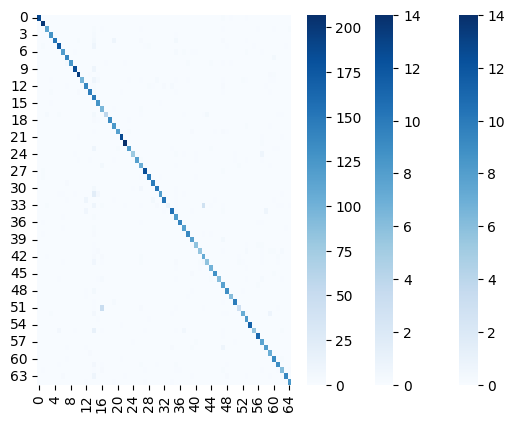

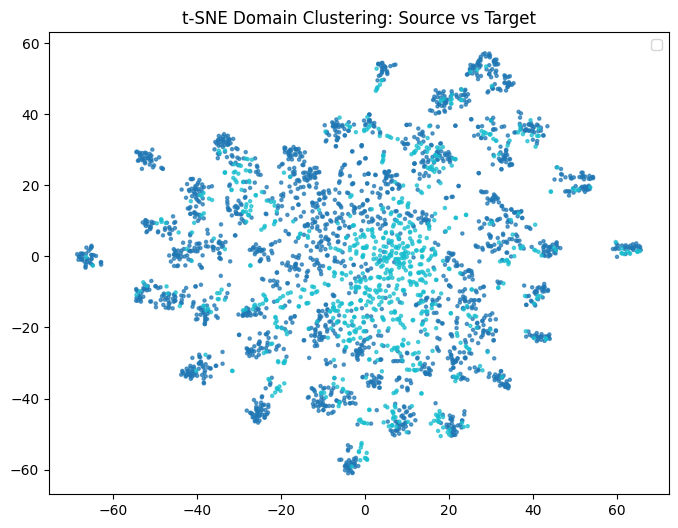

In [75]:
config = {'epochs': 10, 
          'lr':1e-2, 
          'batch_size':32, 
          'weight_decay':1e-3, 
          'sigmas':[2e-16,2e-12,2e-8,2e-4,2e+0,2e+4,2e+8,2e+12,2e+16], 
          'scale':16.0
          }
analysis(source=["Art", "Real World", "Product"], target=["Clipart"], config=config, cache_source=cache_source, cache_target=cache_target)

NameError: name 'cache_source_train' is not defined